# Transforming ARPEGE raw data to a more readable format

This Notebook transforms to Arpege weather forecast data from the raw format to a more readable format. The raw data is in GRIB format, which is not easy to read.
In addition, there are to many informations.

This notebook:
1. Opens the GRIB files to XArray Datasets
2. group by regions
3. Compute the mean of the variables for each region
4. Save the data in a CSV file

This notebook has been transformed to a script to be run : `./transform_arpege_data.py`

In [1]:
from pathlib import Path
import pandas as pd
import xarray as xr
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon, MultiPolygon
import shapely.plotting
import geojson
from dask.diagnostics import ProgressBar
from functools import partial
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dask.distributed import Client


pbar = ProgressBar()
pbar.register()

In [2]:
start_date = "2022-02-01"
end_date = "2024-04-08"
list_date = pd.date_range(start=start_date, end=end_date, freq="D")
list_date = list_date.strftime("%Y-%m-%d")
cases_forecast = {
    "J+0": ["00H12H", "13H24H"],
    "J+1": ["25H36H", "37H48H"],
    "J+2": ["49H60H", "61H72H"],
    "J+3": ["73H84H", "85H96H"],
}
cases = cases_forecast["J+0"]
filename_to_save_template = (
    "/shared/home/antoine-2etavant/data/arpege/{date}_SP1_{case}.grib2"
)


filename = filename_to_save_template.format(date=list_date[-1], case=cases[1])

number_of_days_to_process = 10
filenames_morning = [
    filename_to_save_template.format(date=date, case=cases[0])
    for date in list_date[:number_of_days_to_process]
]
filenames_afternoon = [
    filename_to_save_template.format(date=date, case=cases[1])
    for date in list_date[:number_of_days_to_process]
]

filenames_morning_exist = [
    filename for filename in filenames_morning if Path(filename).exists()
]
filenames_afternoon_exist = [
    filename for filename in filenames_afternoon if Path(filename).exists()
]

filenames_morning = filenames_morning_exist
filenames_afternoon = filenames_afternoon_exist

try:
    ## remove a file that is not working properly
    filenames_afternoon.remove(
        "/shared/home/antoine-2etavant/data/arpege/2023-08-20_SP1_13H24H.grib2"
    )
except:
    pass

save_parquet = number_of_days_to_process == -1

# Open a list a Grib files

The following section opens a list of grib files and merge them intoo one XArray.

It requieres to av install Dask and CFGrid in addition to xarray, that can be install with
```bash
mamba install -y -c conda-forge dask xarray cfgrib flox
```

In [3]:
KEYS_FILTER_SSPD = {
    "typeOfLevel": "surface",
    "cfVarName": "ssrd",
}
KEYS_FILTER_WIND = {
    "typeOfLevel": "heightAboveGround",
    "level": 10,
    "cfVarName": "si10",
}
KEYS_FILTER_T2M = {
    "typeOfLevel": "heightAboveGround",
    "level": 2,
    "cfVarName": "t2m",
}

In [4]:
da = xr.open_mfdataset(
    filenames_morning,
    engine="cfgrib",
    # parallel=True,
    backend_kwargs={"filter_by_keys": KEYS_FILTER_T2M},
    concat_dim="time",
    combine="nested",
    # chunks={"time": 1},
).t2m.drop_vars("heightAboveGround")
da

[########################################] | 100% Completed | 102.53 ms
[########################################] | 100% Completed | 101.46 ms


<xarray.DataArray 't2m' (time: 10, step: 13, latitude: 521, longitude: 741)> Size: 201MB
dask.array<concatenate, shape=(10, 13, 521, 741), dtype=float32, chunksize=(1, 13, 521, 741), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 80B 2022-02-01 2022-02-02 ... 2022-02-10
  * step        (step) timedelta64[ns] 104B 00:00:00 01:00:00 ... 12:00:00
  * latitude    (latitude) float64 4kB 72.0 71.9 71.8 71.7 ... 20.2 20.1 20.0
  * longitude   (longitude) float64 6kB -32.0 -31.9 -31.8 ... 41.8 41.9 42.0
    valid_time  (time, step) datetime64[ns] 1kB dask.array<chunksize=(1, 13), meta=np.ndarray>
Attributes: (12/29)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

[########################################] | 100% Completed | 2.23 sms
[########################################] | 100% Completed | 101.58 ms


(<Figure size 640x480 with 2 Axes>,
 <GeoAxes: title={'center': '2 metre temperature\n at 2022-02-01T00:00:00.000000000'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

/home/ubuntu/.local/mambaforge/envs/latest/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/ubuntu/.local/mambaforge/envs/latest/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


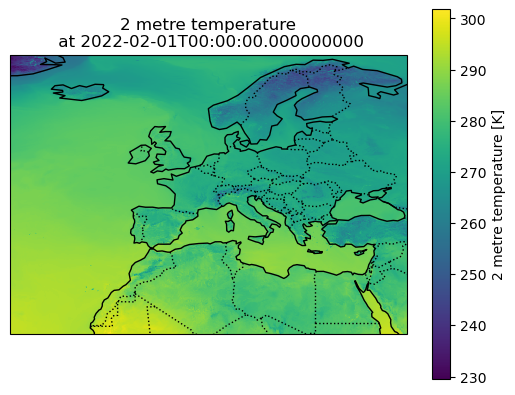

In [5]:
def show_da(da):
    fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
    dasel = da.isel(time=0, step=0)
    dasel.plot(ax=ax, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.STATES, linestyle=":")
    ax.set_title(dasel.long_name + "\n at " + str(dasel.valid_time.values))
    return fig, ax


show_da(da)

# Selecting the France region

The weather forecast is for the whole world. We are only interested in the France region. We will select the data for this region.

number of polygons: 2


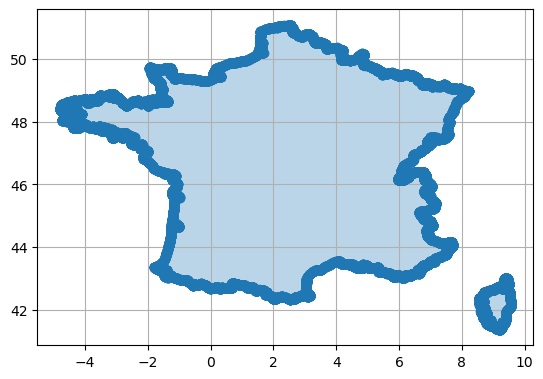

In [6]:
# create mask if point inside metropole
metropole_geojson_file = "../datascience/metropole.geojson"
metropole = geojson.load(open(metropole_geojson_file))
polys_france = [Polygon(geo[0]) for geo in metropole["geometry"]["coordinates"]]
areas = [p.area for p in polys_france]

min_area = 0.2  # threshold to remove small islands
polys_france = [p for p, area in zip(polys_france, areas) if area > min_area]
print(f"number of polygons: {len(polys_france)}")
poly_france = MultiPolygon(polys_france)
# poly_france = polys_france[0]  # france metropolitan

bouns = poly_france.envelope.bounds
min_lon = bouns[0]
max_lon = bouns[2]
min_lat = bouns[1]
max_lat = bouns[3]

for poly in poly_france.geoms:
    shapely.plotting.plot_polygon(poly)

In [9]:
def select_region(ds, min_lon, max_lon, min_lat, max_lat):
    """Check if 'step' is in the dataset's coordinates
    and return the dataset with the selected region.
    """
    if "step" not in ds.coords:
        print("step not in coords")
        display(ds)
    return ds.sel(longitude=slice(min_lon, max_lon), latitude=slice(max_lat, min_lat))


select_france = partial(
    select_region, min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat
)

da = xr.open_mfdataset(
    filenames_morning,
    engine="cfgrib",
    # parallel=True,
    backend_kwargs={"filter_by_keys": KEYS_FILTER_T2M},
    concat_dim="time",
    combine="nested",
    preprocess=select_france,
    # chunks={"time": 1},
).t2m.drop_vars("heightAboveGround")
da

[########################################] | 100% Completed | 102.74 ms
[########################################] | 100% Completed | 105.12 ms


<xarray.DataArray 't2m' (time: 10, step: 13, latitude: 97, longitude: 143)> Size: 7MB
dask.array<concatenate, shape=(10, 13, 97, 143), dtype=float32, chunksize=(1, 13, 97, 143), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 80B 2022-02-01 2022-02-02 ... 2022-02-10
  * step        (step) timedelta64[ns] 104B 00:00:00 01:00:00 ... 12:00:00
  * latitude    (latitude) float64 776B 51.0 50.9 50.8 50.7 ... 41.6 41.5 41.4
  * longitude   (longitude) float64 1kB -4.7 -4.6 -4.5 -4.4 ... 9.2 9.3 9.4 9.5
    valid_time  (time, step) datetime64[ns] 1kB dask.array<chunksize=(1, 13), meta=np.ndarray>
Attributes: (12/29)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

[                                        ] | 0% Completed | 187.27 us

[########################################] | 100% Completed | 2.02 sms
[########################################] | 100% Completed | 101.65 ms


(<Figure size 640x480 with 2 Axes>,
 <GeoAxes: title={'center': '2 metre temperature\n at 2022-02-01T00:00:00.000000000'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

/home/ubuntu/.local/mambaforge/envs/latest/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


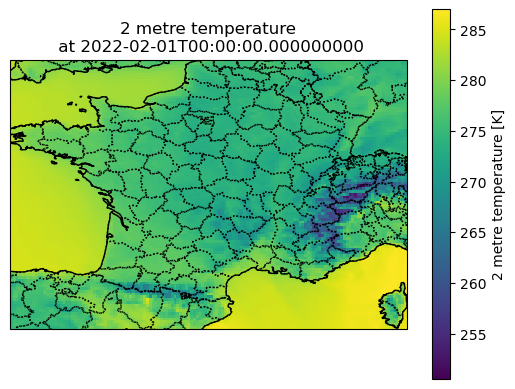

In [10]:
show_da(da)

### Labelling regions

Some the of analysis require averages over the Regions of France. We will label the regions of France to perform a groupby operation.

Île-de-France
Centre-Val de Loire
Bourgogne-Franche-Comté
Normandie
Hauts-de-France
Grand Est
Pays de la Loire
Bretagne
Nouvelle-Aquitaine
Guadeloupe
Martinique
Guyane
La Réunion
Mayotte
Occitanie
Auvergne-Rhône-Alpes
Provence-Alpes-Côte d'Azur
Corse


  0%|          | 0/18 [00:00<?, ?it/s]

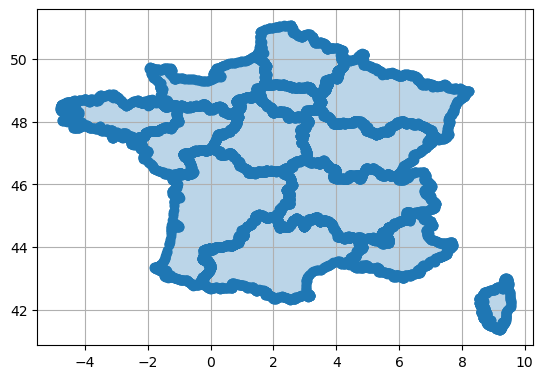

In [11]:
filename = "../datascience/regions.geojson"
polys = geojson.load(open(filename))
for feature in polys["features"]:
    print(feature["properties"]["nom"])

names_to_keep = [
    "Bretagne",
    "Centre-Val de Loire",
    "Grand Est",
    "Hauts-de-France",
    "Île-de-France",
    "Normandie",
    "Nouvelle-Aquitaine",
    "Occitanie",
    "Pays de la Loire",
    "Provence-Alpes-Côte d'Azur",
    "Bourgogne-Franche-Comté",
    "Auvergne-Rhône-Alpes",
    "Corse",
]

polys_region = {}
for feature in tqdm(polys["features"]):
    name = feature["properties"]["nom"]
    if name not in names_to_keep:
        continue
    if feature["geometry"]["type"] == "Polygon":
        polys_region[name] = Polygon(feature["geometry"]["coordinates"][0])
    elif feature["geometry"]["type"] == "MultiPolygon":
        # keeping the largest polygon
        tmp_list = [Polygon(geo[0]) for geo in feature["geometry"]["coordinates"]]
        largest = max(tmp_list, key=lambda x: x.area)
        polys_region[name] = Polygon(largest)


all_polys = [poly for poly in polys_region.values()]
# unpack the lists
maxi_multi_poly = MultiPolygon(all_polys)
for poly in maxi_multi_poly.geoms:
    shapely.plotting.plot_polygon(poly)

## Create masks to groupby

This section aims to labbel each point of the grid with the region it belongs to.
By doing so, we can use the groupby method to select the region we want.

In [12]:
def which_region(lon, lat, polygons_regions: dict[MultiPolygon]):
    for i, (name, poly) in enumerate(polygons_regions.items()):
        if poly.contains(Point(lon, lat)):
            return i
    else:
        return np.nan


mask = xr.apply_ufunc(
    which_region,
    da.longitude,
    da.latitude,
    kwargs={"polygons_regions": polys_region},
    vectorize=True,
    dask="parallelized",
)

In [13]:
mask

<xarray.DataArray (longitude: 143, latitude: 97)> Size: 111kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 1kB -4.7 -4.6 -4.5 -4.4 ... 9.2 9.3 9.4 9.5
  * latitude   (latitude) float64 776B 51.0 50.9 50.8 50.7 ... 41.6 41.5 41.4

In [22]:
mask.to_netcdf("mask_france_regions.nc")
import yaml

with open("regions.yml", "w", encoding="utf-8") as file:
    yaml.dump(list(polys_region.keys()), file, allow_unicode=True)

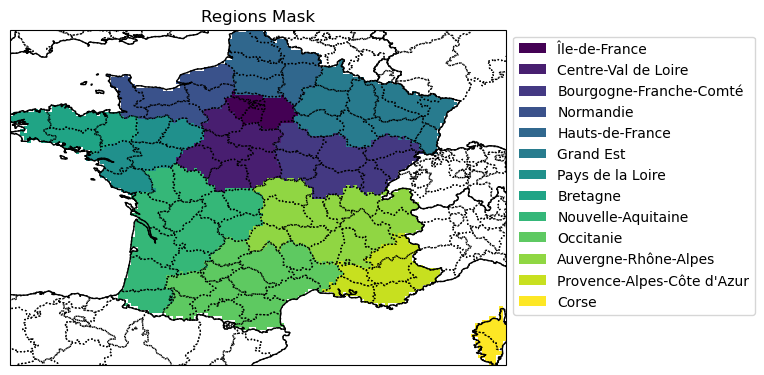

In [14]:
def show_mask(m):
    fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
    im = ax.imshow(
        m.T,
        origin="upper",
        transform=ccrs.PlateCarree(),
        extent=[
            m.longitude.min(),
            m.longitude.max(),
            m.latitude.min(),
            m.latitude.max(),
        ],
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES, linestyle=":")
    ax.set_title("Regions Mask")
    # add a fake legend with the regions
    pacht_list = []
    for i, (name, poly) in enumerate(polys_region.items()):
        color = im.cmap(im.norm(i))
        p = plt.Rectangle((0, 0), 1, 1, fc=color)
        pacht_list.append(p)
    ax.legend(pacht_list, polys_region.keys(), loc="upper left", bbox_to_anchor=(1, 1))


show_mask(mask)

In [13]:
group_means = da.groupby(mask).mean()
# relabel the regions groups
group_means["group"] = list(polys_region.keys())
# change the name of the groups
group_means = group_means.rename(group="region")
group_means

<xarray.DataArray 't2m' (time: 10, step: 13, region: 13)> Size: 7kB
dask.array<getitem, shape=(10, 13, 13), dtype=float32, chunksize=(1, 13, 13), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 80B 2022-02-01 2022-02-02 ... 2022-02-10
  * step        (step) timedelta64[ns] 104B 00:00:00 01:00:00 ... 12:00:00
    valid_time  (time, step) datetime64[ns] 1kB dask.array<chunksize=(1, 13), meta=np.ndarray>
  * region      (region) <U26 1kB 'Île-de-France' ... 'Corse'
Attributes: (12/29)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

In [18]:
df = group_means.to_dask_dataframe()
df

,time,step,region,valid_time,t2m
npartitions=10,,,,,
0,datetime64[ns],timedelta64[ns],string,datetime64[ns],float32
169,...,...,...,...,...
...,...,...,...,...,...
1521,...,...,...,...,...
1689,...,...,...,...,...


In [15]:
df.to_csv("group_means_from_dask.csv", single_file=True)

[########################################] | 100% Completed | 20.39 ss


['/home/ubuntu/hackathon_meteofrance/energetic-stress-production/notebooks/weather/group_means_from_dask.csv']

## The Solar Flux

This section reads the solar flux from the GRIB2 files, an uses XArray to process the means.

In [48]:
number_of_days_to_process = 3
list_of_filenames_from_case = [
    [filename_to_save_template.format(date=date, case=case) for date in list_date[9:10]]
    for case in [
        "00H12H",
        "13H24H",
        "25H36H",
        "37H48H",
        "49H60H",
        "61H72H",
        "73H84H",
        "85H96H",
    ]
]


da_ssrd = xr.concat(
    [
        xr.open_mfdataset(
            list_files,
            engine="cfgrib",
            parallel=True,
            backend_kwargs={"filter_by_keys": KEYS_FILTER_SSPD},
            concat_dim="time",
            combine="nested",
            preprocess=select_france,
            chunks={
                "time": 1,
            },
        ).ssrd.drop_vars("surface")
        for list_files in list_of_filenames_from_case
    ],
    dim="step",
)

[########################################] | 100% Completed | 107.98 ms
[########################################] | 100% Completed | 101.21 ms
[########################################] | 100% Completed | 103.35 ms
[########################################] | 100% Completed | 101.86 ms
[########################################] | 100% Completed | 101.90 ms
[########################################] | 100% Completed | 101.33 ms
[########################################] | 100% Completed | 101.74 ms
[########################################] | 100% Completed | 101.54 ms
[########################################] | 100% Completed | 101.36 ms
[########################################] | 100% Completed | 101.65 ms
[########################################] | 100% Completed | 101.67 ms
[########################################] | 100% Completed | 101.64 ms
[########################################] | 100% Completed | 101.95 ms
[########################################] | 100% Completed | 10

In [49]:
da_ssrd

<xarray.DataArray 'ssrd' (time: 3, step: 96, latitude: 97, longitude: 143)> Size: 16MB
dask.array<concatenate, shape=(3, 96, 97, 143), dtype=float32, chunksize=(1, 12, 97, 143), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 24B 2022-02-01 2022-02-02 2022-02-03
  * step        (step) timedelta64[ns] 768B 01:00:00 ... 4 days 00:00:00
  * latitude    (latitude) float64 776B 51.0 50.9 50.8 50.7 ... 41.6 41.5 41.4
  * longitude   (longitude) float64 1kB -4.7 -4.6 -4.5 -4.4 ... 9.2 9.3 9.4 9.5
    valid_time  (time, step) datetime64[ns] 2kB dask.array<chunksize=(1, 12), meta=np.ndarray>
Attributes: (12/29)
    GRIB_paramId:                             169
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_name:                                Surface short-wave (solar) radi...
    GRIB_shortName:                           ssrd
    GRIB_units:                               J m**-2
    long_name:                                Surface short-wave (solar) radi...
    units:                                    J m**-2
    standard_name:                            surface_downwelling_shortwave_f...

In [50]:
da_ssrd_groups = da_ssrd.groupby(mask).mean()
da_ssrd_groups["group"] = list(polys_region.keys())
da_ssrd_groups = da_ssrd_groups.rename(group="region")
da_ssrd_groups

<xarray.DataArray 'ssrd' (time: 3, step: 96, region: 13)> Size: 15kB
dask.array<getitem, shape=(3, 96, 13), dtype=float32, chunksize=(1, 12, 13), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 24B 2022-02-01 2022-02-02 2022-02-03
  * step        (step) timedelta64[ns] 768B 01:00:00 ... 4 days 00:00:00
    valid_time  (time, step) datetime64[ns] 2kB dask.array<chunksize=(1, 12), meta=np.ndarray>
  * region      (region) <U26 1kB 'Île-de-France' ... 'Corse'
Attributes: (12/29)
    GRIB_paramId:                             169
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_name:                                Surface short-wave (solar) radi...
    GRIB_shortName:                           ssrd
    GRIB_units:                               J m**-2
    long_name:                                Surface short-wave (solar) radi...
    units:                                    J m**-2
    standard_name:                            surface_downwelling_shortwave_f...

In [51]:
da_ssrd_groups.compute()

[########################################] | 100% Completed | 66.64 ss


<xarray.DataArray 'ssrd' (time: 3, step: 96, region: 13)> Size: 15kB
array([[[5.21495798e-11, 5.18640686e-11, 5.33351072e-11, ...,
         6.19532967e-11, 5.94541430e-11, 5.53713672e-11],
        [1.04299160e-10, 1.03728144e-10, 1.06689421e-10, ...,
         1.23917612e-10, 1.18910992e-10, 1.10739265e-10],
        [1.56449048e-10, 1.55592039e-10, 1.60071026e-10, ...,
         1.85885057e-10, 1.78367016e-10, 1.66105893e-10],
        ...,
        [9.31382400e+06, 1.11913400e+07, 1.14233900e+07, ...,
         2.57620740e+07, 4.07510760e+07, 4.06120120e+07],
        [9.31382400e+06, 1.11913400e+07, 1.14233900e+07, ...,
         2.57620740e+07, 4.07510760e+07, 4.06120120e+07],
        [9.31382400e+06, 1.11913400e+07, 1.14233900e+07, ...,
         2.57620740e+07, 4.07510760e+07, 4.06120120e+07]],

       [[5.21496388e-11, 5.18638812e-11, 5.36186338e-11, ...,
         6.26886182e-11, 5.95199237e-11, 5.52645534e-11],
        [1.04299278e-10, 1.03727762e-10, 1.07237344e-10, ...,
         1.25426683e-10, 1.19064286e-10, 1.10526234e-10],
        [1.56448590e-10, 1.55592150e-10, 1.60855565e-10, ...,
         1.88208338e-10, 1.78626211e-10, 1.65785885e-10],
...
        [1.30804860e+07, 1.62362110e+07, 1.51365840e+07, ...,
         2.80159060e+07, 4.06069240e+07, 3.94179320e+07],
        [1.30804860e+07, 1.62362110e+07, 1.51365840e+07, ...,
         2.80159060e+07, 4.06069240e+07, 3.94179320e+07],
        [1.30804860e+07, 1.62362110e+07, 1.51365840e+07, ...,
         2.80159060e+07, 4.06069240e+07, 3.94179320e+07]],

       [[5.21496388e-11, 5.18638812e-11, 5.33832249e-11, ...,
         6.25098445e-11, 5.93695024e-11, 5.51295502e-11],
        [1.04299278e-10, 1.03727762e-10, 1.06757131e-10, ...,
         1.24999552e-10, 1.18730761e-10, 1.10256533e-10],
        [1.56448590e-10, 1.55592150e-10, 1.60123290e-10, ...,
         1.87470151e-10, 1.78083950e-10, 1.65382236e-10],
        ...,
        [1.29457220e+07, 1.53805090e+07, 1.91645320e+07, ...,
         3.06156140e+07, 3.98566920e+07, 3.77660880e+07],
        [1.29457220e+07, 1.53805090e+07, 1.91645320e+07, ...,
         3.06156140e+07, 3.98566920e+07, 3.77660880e+07],
        [1.29457220e+07, 1.53805090e+07, 1.91645320e+07, ...,
         3.06156140e+07, 3.98566920e+07, 3.77660880e+07]]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 24B 2022-02-01 2022-02-02 2022-02-03
  * step        (step) timedelta64[ns] 768B 01:00:00 ... 4 days 00:00:00
    valid_time  (time, step) datetime64[ns] 2kB 2022-02-01T01:00:00 ... 2022-...
  * region      (region) <U26 1kB 'Île-de-France' ... 'Corse'
Attributes: (12/29)
    GRIB_paramId:                             169
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_name:                                Surface short-wave (solar) radi...
    GRIB_shortName:                           ssrd
    GRIB_units:                               J m**-2
    long_name:                                Surface short-wave (solar) radi...
    units:                                    J m**-2
    standard_name:                            surface_downwelling_shortwave_f...

In [52]:
# insert a value of zero at the index step = 0
zero_da = xr.zeros_like(da_ssrd_groups.isel(step=0))
zero_da["step"] = pd.Timedelta("0h")
zero_da["valid_time"] -= pd.Timedelta("1h")
zero_da

<xarray.DataArray 'ssrd' (time: 3, region: 13)> Size: 156B
dask.array<full_like, shape=(3, 13), dtype=float32, chunksize=(1, 13), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 24B 2022-02-01 2022-02-02 2022-02-03
    step        timedelta64[ns] 8B 00:00:00
    valid_time  (time) datetime64[ns] 24B dask.array<chunksize=(1,), meta=np.ndarray>
  * region      (region) <U26 1kB 'Île-de-France' ... 'Corse'
Attributes: (12/29)
    GRIB_paramId:                             169
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_name:                                Surface short-wave (solar) radi...
    GRIB_shortName:                           ssrd
    GRIB_units:                               J m**-2
    long_name:                                Surface short-wave (solar) radi...
    units:                                    J m**-2
    standard_name:                            surface_downwelling_shortwave_f...

In [54]:
da_ssrd_padded = xr.concat([zero_da, da_ssrd_groups], dim="step")
da_ssrd_padded.compute()

[                                        ] | 0% Completed | 3.10 ms

[########################################] | 100% Completed | 64.05 ss


<xarray.DataArray 'ssrd' (time: 3, region: 13, step: 97)> Size: 15kB
array([[[0.00000000e+00, 5.21495798e-11, 1.04299160e-10, ...,
         9.31382400e+06, 9.31382400e+06, 9.31382400e+06],
        [0.00000000e+00, 5.18640686e-11, 1.03728144e-10, ...,
         1.11913400e+07, 1.11913400e+07, 1.11913400e+07],
        [0.00000000e+00, 5.33351072e-11, 1.06689421e-10, ...,
         1.14233900e+07, 1.14233900e+07, 1.14233900e+07],
        ...,
        [0.00000000e+00, 6.19532967e-11, 1.23917612e-10, ...,
         2.57620740e+07, 2.57620740e+07, 2.57620740e+07],
        [0.00000000e+00, 5.94541430e-11, 1.18910992e-10, ...,
         4.07510760e+07, 4.07510760e+07, 4.07510760e+07],
        [0.00000000e+00, 5.53713672e-11, 1.10739265e-10, ...,
         4.06120120e+07, 4.06120120e+07, 4.06120120e+07]],

       [[0.00000000e+00, 5.21496388e-11, 1.04299278e-10, ...,
         1.30804860e+07, 1.30804860e+07, 1.30804860e+07],
        [0.00000000e+00, 5.18638812e-11, 1.03727762e-10, ...,
         1.62362110e+07, 1.62362110e+07, 1.62362110e+07],
        [0.00000000e+00, 5.36186338e-11, 1.07237344e-10, ...,
         1.51365840e+07, 1.51365840e+07, 1.51365840e+07],
...
        [0.00000000e+00, 6.26886182e-11, 1.25426683e-10, ...,
         2.80159060e+07, 2.80159060e+07, 2.80159060e+07],
        [0.00000000e+00, 5.95199237e-11, 1.19064286e-10, ...,
         4.06069240e+07, 4.06069240e+07, 4.06069240e+07],
        [0.00000000e+00, 5.52645534e-11, 1.10526234e-10, ...,
         3.94179320e+07, 3.94179320e+07, 3.94179320e+07]],

       [[0.00000000e+00, 5.21496388e-11, 1.04299278e-10, ...,
         1.29457220e+07, 1.29457220e+07, 1.29457220e+07],
        [0.00000000e+00, 5.18638812e-11, 1.03727762e-10, ...,
         1.53805090e+07, 1.53805090e+07, 1.53805090e+07],
        [0.00000000e+00, 5.33832249e-11, 1.06757131e-10, ...,
         1.91645320e+07, 1.91645320e+07, 1.91645320e+07],
        ...,
        [0.00000000e+00, 6.25098445e-11, 1.24999552e-10, ...,
         3.06156140e+07, 3.06156140e+07, 3.06156140e+07],
        [0.00000000e+00, 5.93695024e-11, 1.18730761e-10, ...,
         3.98566920e+07, 3.98566920e+07, 3.98566920e+07],
        [0.00000000e+00, 5.51295502e-11, 1.10256533e-10, ...,
         3.77660880e+07, 3.77660880e+07, 3.77660880e+07]]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 24B 2022-02-01 2022-02-02 2022-02-03
  * step        (step) timedelta64[ns] 776B 00:00:00 ... 4 days 00:00:00
    valid_time  (time, step) datetime64[ns] 2kB 2022-02-01 ... 2022-02-07
  * region      (region) <U26 1kB 'Île-de-France' ... 'Corse'
Attributes: (12/29)
    GRIB_paramId:                             169
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            accum
    ...                                       ...
    GRIB_name:                                Surface short-wave (solar) radi...
    GRIB_shortName:                           ssrd
    GRIB_units:                               J m**-2
    long_name:                                Surface short-wave (solar) radi...
    units:                                    J m**-2
    standard_name:                            surface_downwelling_shortwave_f...

In [55]:
# compute the diff along the step dimension
da_ssrd_hourly = da_ssrd_padded.diff("step")
da_ssrd_hourly["step"] = da_ssrd_padded.step[:-1]
da_ssrd_hourly["valid_time"] -= pd.Timedelta("1h")
da_ssrd_hourly

<xarray.DataArray 'ssrd' (time: 3, region: 13, step: 96)> Size: 15kB
dask.array<sub, shape=(3, 13, 96), dtype=float32, chunksize=(1, 13, 11), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 24B 2022-02-01 2022-02-02 2022-02-03
    valid_time  (time, step) datetime64[ns] 2kB dask.array<chunksize=(1, 12), meta=np.ndarray>
  * region      (region) <U26 1kB 'Île-de-France' ... 'Corse'
  * step        (step) timedelta64[ns] 768B 00:00:00 ... 3 days 23:00:00

In [56]:
da_ssrd_hourly.unify_chunks()

<xarray.DataArray 'ssrd' (time: 3, region: 13, step: 96)> Size: 15kB
dask.array<sub, shape=(3, 13, 96), dtype=float32, chunksize=(1, 13, 11), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 24B 2022-02-01 2022-02-02 2022-02-03
    valid_time  (time, step) datetime64[ns] 2kB dask.array<chunksize=(1, 1), meta=np.ndarray>
  * region      (region) <U26 1kB 'Île-de-France' ... 'Corse'
  * step        (step) timedelta64[ns] 768B 00:00:00 ... 3 days 23:00:00

In [57]:
df_mean_ssrd = da_ssrd_hourly.unify_chunks().to_dask_dataframe()
df_mean_ssrd

,time,step,region,valid_time,ssrd
npartitions=3,,,,,
0,datetime64[ns],timedelta64[ns],string,datetime64[ns],float32
1248,...,...,...,...,...
2496,...,...,...,...,...
3743,...,...,...,...,...


In [58]:
df_mean_ssrd.to_csv("group_means_ssrd_from_dask.csv", single_file=True)

[                                        ] | 0% Completed | 280.23 us

[########################################] | 100% Completed | 65.71 s


['/home/ubuntu/hackathon_meteofrance/energetic-stress-production/notebooks/weather/group_means_ssrd_from_dask.csv']

In [32]:
order_of_multiindex = ["time", "step", "region"]
# reorder level and sort the index
df_mean_ssrd = df_mean_ssrd.reorder_levels(order_of_multiindex).sort_index()
df_mean_ssrd

valid_time  \
time       step            region                                           
2022-02-01 0 days 00:00:00 Auvergne-Rhône-Alpes       2022-02-01 00:00:00   
                           Bourgogne-Franche-Comté    2022-02-01 00:00:00   
                           Bretagne                   2022-02-01 00:00:00   
                           Centre-Val de Loire        2022-02-01 00:00:00   
                           Corse                      2022-02-01 00:00:00   
...                                                                   ...   
2022-02-10 0 days 23:00:00 Nouvelle-Aquitaine         2022-02-10 23:00:00   
                           Occitanie                  2022-02-10 23:00:00   
                           Pays de la Loire           2022-02-10 23:00:00   
                           Provence-Alpes-Côte d'Azur 2022-02-10 23:00:00   
                           Île-de-France              2022-02-10 23:00:00   

                                                               ssrd  
time       step            region                                    
2022-02-01 0 days 00:00:00 Auvergne-Rhône-Alpes        6.195330e-11  
                           Bourgogne-Franche-Comté     5.333511e-11  
                           Bretagne                    5.238319e-11  
                           Centre-Val de Loire         5.186407e-11  
                           Corse                       5.537137e-11  
...                                                             ...  
2022-02-10 0 days 23:00:00 Nouvelle-Aquitaine          0.000000e+00  
                           Occitanie                   0.000000e+00  
                           Pays de la Loire            0.000000e+00  
                           Provence-Alpes-Côte d'Azur  0.000000e+00  
                           Île-de-France               0.000000e+00  

[3120 rows x 2 columns]

### Refactoring in one function

In [109]:
def process_ssrd(number_of_days_to_process=10):
    list_of_filenames_from_case = [
        [
            filename_to_save_template.format(date=date, case=case)
            for date in list_date[:number_of_days_to_process]
        ]
        for case in [
            "00H12H",
            "13H24H",
            "25H36H",
            "37H48H",
            "49H60H",
            "61H72H",
            "73H84H",
            "85H96H",
        ]
    ]

    da_ssrd = xr.concat(
        [
            xr.open_mfdataset(
                list_files,
                engine="cfgrib",
                # parallel=True,
                backend_kwargs={"filter_by_keys": KEYS_FILTER_SSPD},
                concat_dim="time",
                combine="nested",
                preprocess=select_france,
                # chunks={"time": 1},
            ).ssrd.drop_vars("surface")
            for list_files in list_of_filenames_from_case
        ],
        dim="step",
    )
    # Grouping as fast as possible to speed the other operations
    da_ssrd_groups = da_ssrd.groupby(mask).mean()
    da_ssrd_groups["group"] = list(polys_region.keys())
    da_ssrd_groups = da_ssrd_groups.rename(group="region")
    # insert a value of zero at the index step = 0
    zero_da = xr.zeros_like(da_ssrd_groups.isel(step=0))
    zero_da["step"] = pd.Timedelta("0h")
    zero_da["valid_time"] -= pd.Timedelta("1h")
    da_ssrd_padded = xr.concat([zero_da, da_ssrd_groups], dim="step")
    # compute the diff along the step dimension
    da_ssrd_hourly = da_ssrd_padded.diff("step")
    da_ssrd_hourly["step"] = da_ssrd_padded.step[:-1]
    da_ssrd_hourly["valid_time"] -= pd.Timedelta("1h")

    return da_ssrd_hourly


da_ssrd_hourly = process_ssrd(number_of_days_to_process=10)
da_ssrd_hourly

<xarray.DataArray 'ssrd' (time: 10, region: 13, step: 96)> Size: 50kB
dask.array<sub, shape=(10, 13, 96), dtype=float32, chunksize=(1, 13, 11), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 80B 2022-02-01 2022-02-02 ... 2022-02-10
    valid_time  (time, step) datetime64[ns] 8kB dask.array<chunksize=(1, 12), meta=np.ndarray>
  * region      (region) <U26 1kB 'Île-de-France' ... 'Corse'
  * step        (step) timedelta64[ns] 768B 00:00:00 ... 3 days 23:00:00

### Process all the Sun Flux data

In [ ]:
if False:
    da_ssrd_hourly = process_ssrd(number_of_days_to_process=-1)
    df_mean_ssrd = da_ssrd_hourly.to_dataframe()
    df_mean_ssrd.to_csv("regions_mean_ssrd.csv")

## Processing the mean wind speed

In [110]:
list_of_filenames_from_case

[['/shared/home/antoine-2etavant/data/arpege/2022-02-01_SP1_00H12H.grib2',
  '/shared/home/antoine-2etavant/data/arpege/2022-02-02_SP1_00H12H.grib2',
  '/shared/home/antoine-2etavant/data/arpege/2022-02-03_SP1_00H12H.grib2',
  '/shared/home/antoine-2etavant/data/arpege/2022-02-04_SP1_00H12H.grib2',
  '/shared/home/antoine-2etavant/data/arpege/2022-02-05_SP1_00H12H.grib2',
  '/shared/home/antoine-2etavant/data/arpege/2022-02-06_SP1_00H12H.grib2',
  '/shared/home/antoine-2etavant/data/arpege/2022-02-07_SP1_00H12H.grib2',
  '/shared/home/antoine-2etavant/data/arpege/2022-02-08_SP1_00H12H.grib2',
  '/shared/home/antoine-2etavant/data/arpege/2022-02-09_SP1_00H12H.grib2',
  '/shared/home/antoine-2etavant/data/arpege/2022-02-10_SP1_00H12H.grib2'],
 ['/shared/home/antoine-2etavant/data/arpege/2022-02-01_SP1_13H24H.grib2',
  '/shared/home/antoine-2etavant/data/arpege/2022-02-02_SP1_13H24H.grib2',
  '/shared/home/antoine-2etavant/data/arpege/2022-02-03_SP1_13H24H.grib2',
  '/shared/home/antoine-

In [112]:
da_wind_10m = xr.concat(
    [
        xr.open_mfdataset(
            filenames,
            engine="cfgrib",
            # parallel=True,
            backend_kwargs={"filter_by_keys": KEYS_FILTER_WIND},
            concat_dim="time",
            preprocess=select_france,
            combine="nested",
        ).si10.drop_vars("heightAboveGround")
        for filenames in list_of_filenames_from_case
    ],
    dim="step",
)
da_wind_10m

<xarray.DataArray 'si10' (time: 10, step: 25, latitude: 97, longitude: 143)> Size: 14MB
dask.array<concatenate, shape=(10, 25, 97, 143), dtype=float32, chunksize=(1, 13, 97, 143), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 80B 2022-02-01 2022-02-02 ... 2022-02-10
  * step        (step) timedelta64[ns] 200B 00:00:00 ... 1 days 00:00:00
  * latitude    (latitude) float64 776B 51.0 50.9 50.8 50.7 ... 41.6 41.5 41.4
  * longitude   (longitude) float64 1kB -4.7 -4.6 -4.5 -4.4 ... 9.2 9.3 9.4 9.5
    valid_time  (time, step) datetime64[ns] 2kB dask.array<chunksize=(1, 13), meta=np.ndarray>
Attributes: (12/29)
    GRIB_paramId:                             207
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                10 metre wind speed
    GRIB_shortName:                           10si
    GRIB_units:                               m s**-1
    long_name:                                10 metre wind speed
    units:                                    m s**-1
    standard_name:                            unknown

In [113]:
group_means_wind = da_wind_10m.groupby(mask).mean()
group_means_wind["group"] = list(polys_region.keys())
group_means_wind = group_means_wind.rename(group="region")
group_means_wind

<xarray.DataArray 'si10' (time: 10, step: 25, region: 13)> Size: 13kB
dask.array<getitem, shape=(10, 25, 13), dtype=float32, chunksize=(1, 13, 13), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 80B 2022-02-01 2022-02-02 ... 2022-02-10
  * step        (step) timedelta64[ns] 200B 00:00:00 ... 1 days 00:00:00
    valid_time  (time, step) datetime64[ns] 2kB dask.array<chunksize=(1, 13), meta=np.ndarray>
  * region      (region) <U26 1kB 'Île-de-France' ... 'Corse'
Attributes: (12/29)
    GRIB_paramId:                             207
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                10 metre wind speed
    GRIB_shortName:                           10si
    GRIB_units:                               m s**-1
    long_name:                                10 metre wind speed
    units:                                    m s**-1
    standard_name:                            unknown

In [114]:
df_mean_wind = group_means_wind.to_dataframe()
df_mean_wind.to_csv("regions_mean_wind_J+0.csv")
df_mean_wind

valid_time      si10
time       step   region                                         
2022-02-01 0 days Île-de-France              2022-02-01  3.167887
                  Centre-Val de Loire        2022-02-01  3.115247
                  Bourgogne-Franche-Comté    2022-02-01  3.203172
                  Normandie                  2022-02-01  3.892746
                  Hauts-de-France            2022-02-01  3.711609
...                                                 ...       ...
2022-02-10 1 days Nouvelle-Aquitaine         2022-02-11  3.432209
                  Occitanie                  2022-02-11  2.188498
                  Auvergne-Rhône-Alpes       2022-02-11  2.452313
                  Provence-Alpes-Côte d'Azur 2022-02-11  1.769398
                  Corse                      2022-02-11  1.952576

[3250 rows x 2 columns]

### Refactoring in one function

In [115]:
def process_wind(number_of_days_to_process=10):
    list_of_filenames_from_case = [
        [
            filename_to_save_template.format(date=date, case=case)
            for date in list_date[:number_of_days_to_process]
        ]
        for case in [
            "00H12H",
            "13H24H",
            "25H36H",
            "37H48H",
            "49H60H",
            "61H72H",
            "73H84H",
            "85H96H",
        ]
    ]
    da_wind_10m = xr.concat(
        [
            xr.open_mfdataset(
                filenames,
                engine="cfgrib",
                # parallel=True,
                backend_kwargs={"filter_by_keys": KEYS_FILTER_WIND},
                concat_dim="time",
                preprocess=select_france,
                combine="nested",
            ).si10.drop_vars("heightAboveGround")
            for filenames in list_of_filenames_from_case
        ],
        dim="step",
    )
    group_means_wind = da_wind_10m.groupby(mask).mean()
    group_means_wind["group"] = list(polys_region.keys())
    group_means_wind = group_means_wind.rename(group="region")
    return group_means_wind


da_wind_10m = process_wind(number_of_days_to_process=10)
da_wind_10m

<xarray.DataArray 'si10' (time: 10, step: 97, region: 13)> Size: 50kB
dask.array<getitem, shape=(10, 97, 13), dtype=float32, chunksize=(1, 13, 13), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) datetime64[ns] 80B 2022-02-01 2022-02-02 ... 2022-02-10
  * step        (step) timedelta64[ns] 776B 00:00:00 ... 4 days 00:00:00
    valid_time  (time, step) datetime64[ns] 8kB dask.array<chunksize=(1, 13), meta=np.ndarray>
  * region      (region) <U26 1kB 'Île-de-France' ... 'Corse'
Attributes: (12/29)
    GRIB_paramId:                             207
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                10 metre wind speed
    GRIB_shortName:                           10si
    GRIB_units:                               m s**-1
    long_name:                                10 metre wind speed
    units:                                    m s**-1
    standard_name:                            unknown

In [116]:
df_mean_wind = da_wind_10m.to_dataframe()
df_mean_wind.to_csv("regions_mean_wind_J+0.csv")
df_mean_wind

valid_time      si10
time       step   region                                         
2022-02-01 0 days Île-de-France              2022-02-01  3.167887
                  Centre-Val de Loire        2022-02-01  3.115247
                  Bourgogne-Franche-Comté    2022-02-01  3.203172
                  Normandie                  2022-02-01  3.892746
                  Hauts-de-France            2022-02-01  3.711609
...                                                 ...       ...
2022-02-10 4 days Nouvelle-Aquitaine         2022-02-14  3.933403
                  Occitanie                  2022-02-14  2.759134
                  Auvergne-Rhône-Alpes       2022-02-14  4.609279
                  Provence-Alpes-Côte d'Azur 2022-02-14  2.855153
                  Corse                      2022-02-14  1.895106

[12610 rows x 2 columns]

# Conclusion

This notebook has shown how to transform the raw data from the ARPEGE weather forecast to a more readable format. We have selected the France region and computed the mean of the solar flux and the wind speed for each region.

The notebook has been transformed to a script to be run : `./transform_arpege_data.py`